In [23]:
import pandas as pd
import numpy as np
import arima
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from scipy.stats import norm, kstest

In [3]:
df = pd.read_csv("data/pars_normal_daily.csv", index_col=0)
df.head()


,mu,sigma
2021-12-01,-0.000060,0.000530
2021-12-02,0.000039,0.000643
2021-12-03,-0.000022,0.000703
2021-12-06,0.000030,0.000565
2021-12-07,0.000053,0.000659


In [4]:
# Check for stationarity
arima.adf_check(df["mu"])
arima.adf_check(df["sigma"])

Augmented Dickey-Fuller Test:
ADF Test Statistic : -6.380010424707947
p-value : 2.2343714059272166e-08
Number of Lags Used : 1
Number of Observations Used : 67
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary
Augmented Dickey-Fuller Test:
ADF Test Statistic : -4.020289290202549
p-value : 0.0013079185626142368
Number of Lags Used : 0
Number of Observations Used : 68
strong evidence against the null hypothesis, reject the null hypothesis. Data has no unit root and is stationary


In [5]:
idx = int(len(df)*0.8)
train, test = df.iloc[:idx], df.iloc[idx:]
train.head(), test.head()

(                  mu     sigma
 2021-12-01 -0.000060  0.000530
 2021-12-02  0.000039  0.000643
 2021-12-03 -0.000022  0.000703
 2021-12-06  0.000030  0.000565
 2021-12-07  0.000053  0.000659,
                   mu     sigma
 2022-02-18 -0.000016  0.000581
 2022-02-22 -0.000027  0.000746
 2022-02-23 -0.000046  0.000690
 2022-02-24  0.000038  0.001633
 2022-02-25  0.000056  0.000609)

In [88]:
pd.DataFrame(df.mu)

,mu
2021-12-01,-0.000060
2021-12-02,0.000039
2021-12-03,-0.000022
2021-12-06,0.000030
2021-12-07,0.000053
...,...
2022-03-04,-0.000021
2022-03-07,-0.000076
2022-03-08,-0.000020
2022-03-09,0.000068


The RMSE is : 5.693034563916318e-05 , Value of p :  10
The RMSE is : 4.78636927718186e-05 , Value of q :  10


/Users/eliaslittle/School/CDS/Stock-Densities/arima.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
/Users/eliaslittle/School/CDS/Stock-Densities/arima.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_


<AxesSubplot:>

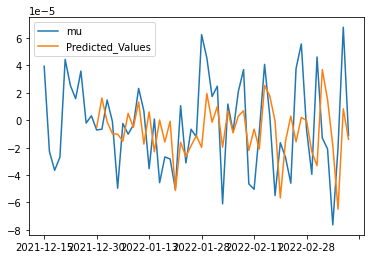

In [12]:
mu_results = arima.arima(10,10,pd.DataFrame(df.mu), 'mu')
mu_results[0][['mu','Predicted_Values']].plot()

The RMSE is : 0.0004191518244928538 , Value of p :  10
The RMSE is : 0.0004466632563606348 , Value of q :  10


/Users/eliaslittle/School/CDS/Stock-Densities/arima.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_
/Users/eliaslittle/School/CDS/Stock-Densities/arima.py:89: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  res_train_2['Predicted_Values'] = X_train.dot(lr.coef_.T) + lr.intercept_


<AxesSubplot:>

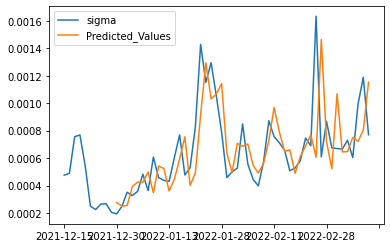

In [13]:
sigma_results = arima.arima(10,10,pd.DataFrame(df.sigma), 'sigma')
sigma_results[0][['sigma','Predicted_Values']].plot()

In [19]:
sigma_hat = sigma_results[0].Predicted_Values[-1]
mu_hat = mu_results[0].Predicted_Values[-1]

In [34]:
inter_day = pd.read_csv("data/SPY_minute.csv", index_col=0)
inter_day.columns = inter_day.iloc[0]
inter_day = inter_day[1:]
inter_day.head(10)

Dates,Close,Volume
SPY US Equity,,
#NAME?,461.27,818361
12/1/21 9:31,460.81,348832
12/1/21 9:32,460.69,331253
12/1/21 9:33,460.76,271748
12/1/21 9:34,460.29,255663
12/1/21 9:35,460.49,287824
12/1/21 9:36,460.53,247480
12/1/21 9:37,460.63,178755
12/1/21 9:38,460.57,235893


In [36]:
inter_day["log"] = np.log(inter_day["Close"].astype(float))
inter_day["deltas"] = inter_day["log"].diff()
inter_day.head(10)

Dates,Close,Volume,log,deltas
SPY US Equity,,,,
#NAME?,461.27,818361,6.133984,NaN
12/1/21 9:31,460.81,348832,6.132986,-0.000998
12/1/21 9:32,460.69,331253,6.132725,-0.000260
12/1/21 9:33,460.76,271748,6.132877,0.000152
12/1/21 9:34,460.29,255663,6.131857,-0.001021
12/1/21 9:35,460.49,287824,6.132291,0.000434
12/1/21 9:36,460.53,247480,6.132378,0.000087
12/1/21 9:37,460.63,178755,6.132595,0.000217
12/1/21 9:38,460.57,235893,6.132465,-0.000130


In [48]:
samples = inter_day.deltas
samples = samples.dropna().tolist()
samples

[-0.0009977443132065389,
 -0.00026044492822130394,
 0.00015193445142891449,
 -0.001020574433082011,
 0.00043441430775104095,
 8.68602202448443e-05,
 0.000217117548293011,
 -0.00013026487209000237,
 -0.0002605806620463724,
 0.0006730278909294896,
 0.00041227718629777144,
 0.0,
 -2.1694562259533257e-05,
 0.0,
 0.0010841519741857653,
 -4.3343519067207126e-05,
 -0.0003403118980527253,
 -0.00024500955768225197,
 -0.0007592603000459164,
 -4.340371970634749e-05,
 0.00043395244562294266,
 -0.00017355838113619626,
 0.000629005866155552,
 -0.0005422229102736154,
 0.0004771716824087946,
 -0.0001734906319414975,
 0.0005962479917771546,
 0.0004225787115723634,
 2.1665890305833102e-05,
 0.0007580105834703588,
 0.0008309854146855145,
 0.0005968445267479083,
 -0.0004973456979397994,
 -0.0002379484528356457,
 0.0004325914457616875,
 -0.0004325914457616875,
 0.0004974640252264351,
 0.000562052804523816,
 0.0003025130211709026,
 0.0001296204283605107,
 -0.00015122546665669034,
 -8.642482126219875e-05,
 -

In [47]:
kstest(samples, lambda x: norm.cdf(x,loc=mu_hat, scale=sigma_hat))

KstestResult(statistic=0.20635413970136715, pvalue=0.0)